# Better Sampling

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", True)

import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

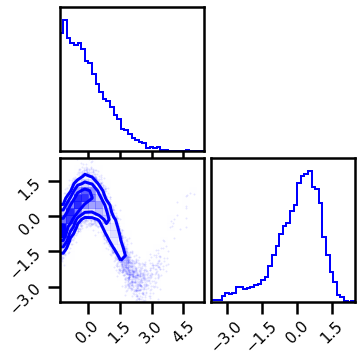

In [11]:
from sklearn.preprocessing import StandardScaler
from rbig_jax.data import NoisySineDataset as PlaneDataset

# %%wandb
# get data
seed = 123
n_samples = 10_000
n_features = 2
# create dataset
ds = PlaneDataset(n_samples=n_samples, seed=123)

data = ds[:]
# standardize data
scaler = StandardScaler().fit(data)
data = scaler.transform(data)

# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)

In [12]:
X = jnp.array(data, dtype=np.float64)

## Model

In [13]:
from rbig_jax.transforms.block import RBIGBlockInit
from rbig_jax.models.iterative import init_default_rbig_block
from rbig_jax.transforms.logit import InitLogitTransform, InitSigmoidTransform
from rbig_jax.transforms.kde import InitUniKDETransform
from rbig_jax.transforms.rotation import InitPCARotation
from rbig_jax.transforms.inversecdf import (
    GaussCDF,
    InverseGaussCDF,
    InitGaussCDF,
    InitInverseGaussCDF,
)

In [14]:
# parameters
data_shape = X.shape
jitted = True
support_extension = 20
init_kde_fs = InitUniKDETransform(
    shape=data_shape, jitted=jitted, support_extension=support_extension
)

# Gaussian version
init_igauss_cdf = InitInverseGaussCDF(jitted=jitted)

# init rotation
init_pca_fs = InitPCARotation(jitted=jitted)

In [15]:
method = "histogram"
# initializae block
# rbig_block_init_fs = init_default_rbig_block(shape=data_shape, method=method)

rbig_block_init_fs = [init_kde_fs, init_igauss_cdf, init_pca_fs]

# create an RBIG "block" init
rbig_block_init = RBIGBlockInit(init_functions=rbig_block_init_fs)

In [16]:
# forward and params
X_g, bijectors = rbig_block_init.forward_and_params(X)

# alternatively just the forward
X_g = rbig_block_init.forward(X)

Text(0.5, 0.98, 'Forward Transformation')

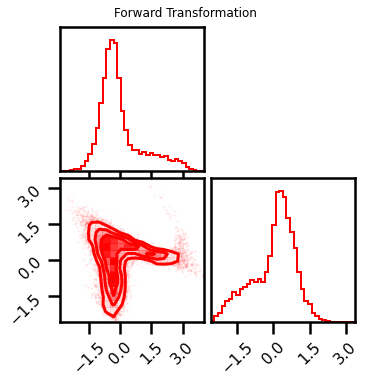

In [17]:
fig = corner.corner(X_g, color="red", hist_bin_factor=2)
fig.suptitle("Forward Transformation")

## Training

In [18]:
from rbig_jax.training.iterative import train_info_loss_model

# define training params
verbose = True
n_layers_remove = 50
interval = 10
max_layers = 100

# run iterative training
X_g, rbig_model_info = train_info_loss_model(
    X=X,
    rbig_block_init=rbig_block_init,
    verbose=verbose,
    interval=interval,
    n_layers_remove=n_layers_remove,
    max_layers=max_layers,
)

Layer 10 - Cum. Info Reduction: 1.488 - Elapsed Time: 5.1815 secs
Layer 20 - Cum. Info Reduction: 1.488 - Elapsed Time: 7.8611 secs
Layer 30 - Cum. Info Reduction: 1.503 - Elapsed Time: 10.6164 secs
Layer 40 - Cum. Info Reduction: 1.503 - Elapsed Time: 14.6601 secs
Layer 50 - Cum. Info Reduction: 1.522 - Elapsed Time: 17.6097 secs
Layer 60 - Cum. Info Reduction: 1.522 - Elapsed Time: 20.5024 secs
Layer 70 - Cum. Info Reduction: 1.522 - Elapsed Time: 23.2650 secs
Layer 80 - Cum. Info Reduction: 1.522 - Elapsed Time: 25.9565 secs
Layer 90 - Cum. Info Reduction: 1.522 - Elapsed Time: 29.2354 secs
Layer 100 - Cum. Info Reduction: 0.522 - Elapsed Time: 32.6665 secs
Converged at Layer: 100
Final Number of layers: 50 (Blocks: 16)
Total Time: 32.6729 secs


#### Information Reduction Evolution

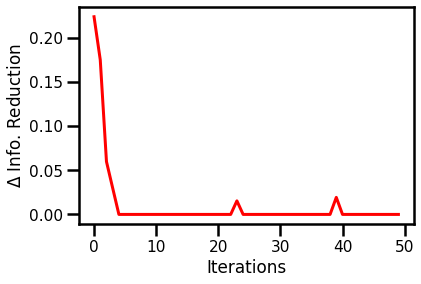

In [19]:
fig, ax = plt.subplots()
ax.plot(rbig_model_info.info_loss, color="red")
ax.set(xlabel="Iterations", ylabel="$\Delta$ Info. Reduction")
plt.show()

#### Negative Log-Likelihood

In [20]:
nll = rbig_model_info.score(X)
print(f"NLL Score: {nll:.4f}")

NLL Score: 1.8425


## Sampling

In [21]:
%%time

# number of samples
n_samples = 100_000
seed = 42

X_samples = rbig_model_info.sample(seed=seed, n_samples=n_samples)

CPU times: user 12.3 s, sys: 949 ms, total: 13.3 s
Wall time: 5.94 s


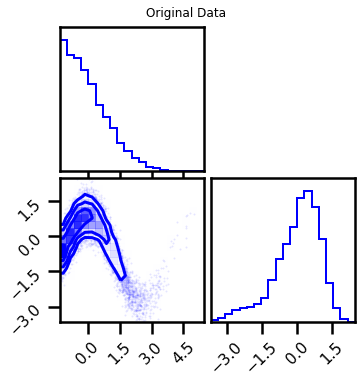

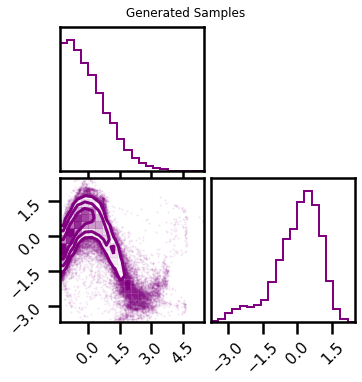

In [22]:
fig = corner.corner(X, color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Better Sampling

In [25]:
from rbig_jax.models.sampling import init_gf_inverse_sampler

In [27]:
rbig_model_sampler = init_gf_inverse_sampler(
    rbig_model_info, marginal_init_f=[init_kde_fs, init_igauss_cdf]
)

Layer: MarginalUniformizeTransform: 100%|██████████| 150/150 [00:00<00:00, 1706.90it/s]


In [28]:
%%time

# number of samples
n_samples = 10_000
seed = 42

X_samples = rbig_model_sampler.sample(seed=seed, n_samples=n_samples, jitted=True)

CPU times: user 2min 10s, sys: 2.51 s, total: 2min 12s
Wall time: 12 s


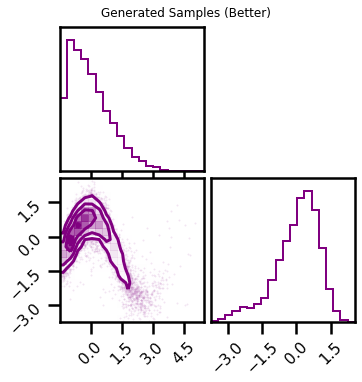

In [29]:
fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples (Better)")
plt.show()

## Saving and Loading

Often times it would be nice to save and load models. This is useful for checkpointing (during training) and also for convenience if you're doing research on google colab.

Fortunately, everything here are python objects, so we can easily save and load our models via `pickle`.

#### Saving

Do to the internals of python (and design choices within this library), one can only store `objects`. So that includes the `rbig_block`, the `bijectors` and also the `rbig_model`. This does not include the `rbig_block_init` for example because that isn't an object, it's a function with some local params.

In [32]:
import pickle

# # save the blocks
# with open("rbig_block.pickle", "wb") as f:
#     pickle.dump(rbig_block, f)

# # save the bijectors
# with open("bijectors.pickle", "wb") as f:
#     pickle.dump(bijectors, f)

# save the full model
import joblib

joblib.dump(rbig_model_info, "rbig_model_info.pickle")

['rbig_model_info.pickle']

#### Loading

Loading is straight forward!

In [33]:
rbig_model_loaded = joblib.load("rbig_model_info.pickle")

#### Simple Test

They won't be the **exact same** byte-for-byte encoding. But they should give the same results either way :).

In [34]:
from rbig_jax.models.sampling import init_gf_inverse_sampler

# parameters
data_shape = X.shape
jitted = True
support_extension = 20
init_kde_fs = InitUniKDETransform(
    shape=data_shape, jitted=jitted, support_extension=support_extension
)

# Gaussian version
init_igauss_cdf = InitInverseGaussCDF(jitted=jitted)


rbig_model_sampler = init_gf_inverse_sampler(
    rbig_model_loaded, marginal_init_f=[init_kde_fs, init_igauss_cdf]
)

Layer: MarginalUniformizeTransform: 100%|██████████| 150/150 [00:00<00:00, 1844.28it/s]


In [35]:
%%time

# number of samples
n_samples = 10_000
seed = 42

X_samples = rbig_model_sampler.sample(seed=seed, n_samples=n_samples, jitted=True)

CPU times: user 2min 10s, sys: 2.46 s, total: 2min 13s
Wall time: 12.6 s


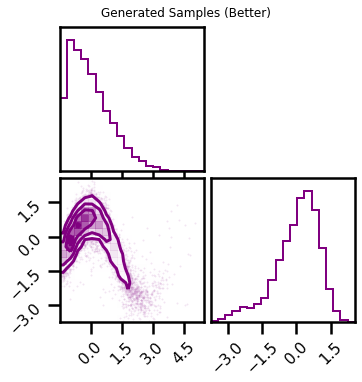

In [36]:
fig2 = corner.corner(X_samples, color="purple")
fig2.suptitle("Generated Samples (Better)")
plt.show()